In [10]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
 

In [12]:
# Exploring Dataset
DIR_TRAIN = "input/train/"
DIR_VALID = "input/valid/"
DIR_TEST = "input/test/"
classes = [c for c in os.listdir(DIR_TRAIN) if not c.startswith('.')]
print("Total Classes: ", len(classes))

# Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.listdir(os.path.join(DIR_TRAIN, _class)))
    valid_count += len(os.listdir(os.path.join(DIR_VALID, _class)))
    test_count += len(os.listdir(os.path.join(DIR_TEST, _class)))

print("Total train images: ", train_count)
print("Total valid images: ", valid_count)
print("Total test images: ", test_count)

Total Classes:  400
Total train images:  58388
Total valid images:  2000
Total test images:  2000


In [13]:
### Creating a list of all images : DIR_TRAIN/class_folder/img.jpg - FOR METHOD 2 of data loading
#   A dict for mapping class labels to index

train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
    
    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)
        
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}
    

In [14]:
### Loading Classification Dataset - FOR METHOD 2: For multi-class data, by inheriting Dataset class

def get_transform():
    return T.Compose([T.ToTensor()])

class BirdDataset(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index]
        
        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        return image, label
        
        
        
    def __len__(self):
        return len(self.imgs_list)

In [15]:
### Loading Classification Dataset

"""
# Method 1: For multi-class data directly from folders using ImageFolder
train_dataset = ImageFolder(root = DIR_TRAIN, transform = T.ToTensor())
valid_dataset = ImageFolder(root = DIR_VALID, transform = T.ToTensor())
test_dataset = ImageFolder(root = DIR_TEST, transform = T.ToTensor())
"""

# Method 2: Using Dataset Class
train_dataset = BirdDataset(train_imgs, class_to_int, get_transform())
valid_dataset = BirdDataset(valid_imgs, class_to_int, get_transform())
test_dataset = BirdDataset(test_imgs, class_to_int, get_transform())

#Data Loader  -  using Sampler (YT Video)
train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

#Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler = train_random_sampler,
)

valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 16,
    sampler = valid_random_sampler,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    sampler = test_random_sampler,
)

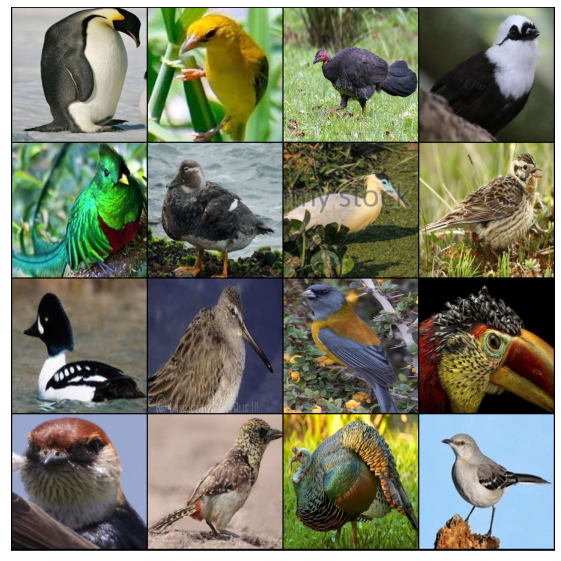

In [16]:
# Visualize one training batch
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [17]:
### Define model
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, len(classes))

In [18]:
### Get device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 20

In [19]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [20]:
### Training Code
from tqdm.auto import tqdm

for epoch in range(epochs):
    start = time.time()
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in tqdm(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        if _iter % 500 == 0:
            print("> Iteration {} < ".format(_iter))
            print("Iter Loss = {}".format(round(loss_value, 4)))
            print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
    
    #Validation
    for images, labels in valid_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = criterion(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))

  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 3.6014
Iter Accuracy = 43.75 % 

> Iteration 1000 < 
Iter Loss = 2.1928
Iter Accuracy = 62.5 % 

> Iteration 1500 < 
Iter Loss = 1.184
Iter Accuracy = 93.75 % 

> Iteration 2000 < 
Iter Loss = 0.834
Iter Accuracy = 93.75 % 

> Iteration 2500 < 
Iter Loss = 0.8737
Iter Accuracy = 81.25 % 

> Iteration 3000 < 
Iter Loss = 0.4421
Iter Accuracy = 87.5 % 

> Iteration 3500 < 
Iter Loss = 0.9269
Iter Accuracy = 75.0 % 

** Epoch 0 ** - Epoch Time 186
Train Loss = 1.8682
Train Accuracy = 67.65239726027397 % 

Val Loss = 0.423
Val Accuracy = 92.1 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.1466
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.604
Iter Accuracy = 93.75 % 

> Iteration 1500 < 
Iter Loss = 0.3167
Iter Accuracy = 93.75 % 

> Iteration 2000 < 
Iter Loss = 0.3843
Iter Accuracy = 87.5 % 

> Iteration 2500 < 
Iter Loss = 0.8172
Iter Accuracy = 81.25 % 

> Iteration 3000 < 
Iter Loss = 0.1862
Iter Accuracy = 93.75 % 

> Iteration 3500 < 
Iter Loss = 0.5165
Iter Accuracy = 93.75 % 

** Epoch 1 ** - Epoch Time 177
Train Loss = 0.4096
Train Accuracy = 91.06506849315069 % 

Val Loss = 0.2028
Val Accuracy = 95.85 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0764
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0702
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.2443
Iter Accuracy = 87.5 % 

> Iteration 2000 < 
Iter Loss = 0.8094
Iter Accuracy = 81.25 % 

> Iteration 2500 < 
Iter Loss = 0.1205
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.4892
Iter Accuracy = 81.25 % 

> Iteration 3500 < 
Iter Loss = 0.1863
Iter Accuracy = 93.75 % 

** Epoch 2 ** - Epoch Time 177
Train Loss = 0.2373
Train Accuracy = 94.4486301369863 % 

Val Loss = 0.1636
Val Accuracy = 95.7 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0834
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0793
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.1427
Iter Accuracy = 93.75 % 

> Iteration 2000 < 
Iter Loss = 0.1525
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.041
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.1168
Iter Accuracy = 93.75 % 

> Iteration 3500 < 
Iter Loss = 0.0232
Iter Accuracy = 100.0 % 

** Epoch 3 ** - Epoch Time 174
Train Loss = 0.1626
Train Accuracy = 95.96061643835617 % 

Val Loss = 0.1326
Val Accuracy = 96.75 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0316
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.01
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.0412
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.1268
Iter Accuracy = 93.75 % 

> Iteration 2500 < 
Iter Loss = 0.0634
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0668
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0957
Iter Accuracy = 100.0 % 

** Epoch 4 ** - Epoch Time 175
Train Loss = 0.1216
Train Accuracy = 96.84246575342466 % 

Val Loss = 0.1547
Val Accuracy = 95.85 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0085
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0659
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.1659
Iter Accuracy = 93.75 % 

> Iteration 2000 < 
Iter Loss = 0.1819
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.0282
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0759
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0146
Iter Accuracy = 100.0 % 

** Epoch 5 ** - Epoch Time 176
Train Loss = 0.0975
Train Accuracy = 97.32191780821918 % 

Val Loss = 0.1306
Val Accuracy = 96.15 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.074
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.325
Iter Accuracy = 93.75 % 

> Iteration 1500 < 
Iter Loss = 0.0162
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0088
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.0232
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.242
Iter Accuracy = 93.75 % 

> Iteration 3500 < 
Iter Loss = 0.0329
Iter Accuracy = 100.0 % 

** Epoch 6 ** - Epoch Time 172
Train Loss = 0.0834
Train Accuracy = 97.70890410958904 % 

Val Loss = 0.1406
Val Accuracy = 96.15 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0089
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0403
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.0671
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0574
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.0266
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.05
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0871
Iter Accuracy = 93.75 % 

** Epoch 7 ** - Epoch Time 173
Train Loss = 0.0734
Train Accuracy = 97.98287671232876 % 

Val Loss = 0.1455
Val Accuracy = 95.95 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0833
Iter Accuracy = 93.75 % 

> Iteration 1000 < 
Iter Loss = 0.0675
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.1536
Iter Accuracy = 93.75 % 

> Iteration 2000 < 
Iter Loss = 0.1611
Iter Accuracy = 87.5 % 

> Iteration 2500 < 
Iter Loss = 0.0136
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0747
Iter Accuracy = 93.75 % 

> Iteration 3500 < 
Iter Loss = 0.0069
Iter Accuracy = 100.0 % 

** Epoch 8 ** - Epoch Time 172
Train Loss = 0.0664
Train Accuracy = 98.12328767123287 % 

Val Loss = 0.1203
Val Accuracy = 96.4 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0206
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0078
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.0185
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0747
Iter Accuracy = 93.75 % 

> Iteration 2500 < 
Iter Loss = 0.0359
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0135
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0084
Iter Accuracy = 100.0 % 

** Epoch 9 ** - Epoch Time 172
Train Loss = 0.0569
Train Accuracy = 98.375 % 

Val Loss = 0.1591
Val Accuracy = 95.25 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0634
Iter Accuracy = 93.75 % 

> Iteration 1000 < 
Iter Loss = 0.0067
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.0103
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.1033
Iter Accuracy = 93.75 % 

> Iteration 2500 < 
Iter Loss = 0.0392
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0106
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0127
Iter Accuracy = 100.0 % 

** Epoch 10 ** - Epoch Time 172
Train Loss = 0.0573
Train Accuracy = 98.39897260273973 % 

Val Loss = 0.1175
Val Accuracy = 96.9 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0509
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0047
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.0047
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0374
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.0157
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0539
Iter Accuracy = 93.75 % 

> Iteration 3500 < 
Iter Loss = 0.0593
Iter Accuracy = 100.0 % 

** Epoch 11 ** - Epoch Time 172
Train Loss = 0.0528
Train Accuracy = 98.43150684931507 % 

Val Loss = 0.1185
Val Accuracy = 96.4 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0088
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0076
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.2436
Iter Accuracy = 93.75 % 

> Iteration 2000 < 
Iter Loss = 0.0074
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.029
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0158
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0205
Iter Accuracy = 100.0 % 

** Epoch 12 ** - Epoch Time 172
Train Loss = 0.0503
Train Accuracy = 98.54109589041096 % 

Val Loss = 0.1563
Val Accuracy = 95.7 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0649
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0042
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.0085
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0449
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.0605
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0107
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.055
Iter Accuracy = 93.75 % 

** Epoch 13 ** - Epoch Time 172
Train Loss = 0.0478
Train Accuracy = 98.58904109589041 % 

Val Loss = 0.1388
Val Accuracy = 95.8 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.002
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0192
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.0106
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0051
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.0027
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0134
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0074
Iter Accuracy = 100.0 % 

** Epoch 14 ** - Epoch Time 172
Train Loss = 0.0468
Train Accuracy = 98.64041095890411 % 

Val Loss = 0.1469
Val Accuracy = 96.15 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0026
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.2347
Iter Accuracy = 93.75 % 

> Iteration 1500 < 
Iter Loss = 0.1062
Iter Accuracy = 93.75 % 

> Iteration 2000 < 
Iter Loss = 0.0409
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.0059
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0094
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0165
Iter Accuracy = 100.0 % 

** Epoch 15 ** - Epoch Time 172
Train Loss = 0.0432
Train Accuracy = 98.70376712328768 % 

Val Loss = 0.1484
Val Accuracy = 96.15 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.3617
Iter Accuracy = 93.75 % 

> Iteration 1000 < 
Iter Loss = 0.0028
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.0519
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0846
Iter Accuracy = 93.75 % 

> Iteration 2500 < 
Iter Loss = 0.0039
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.024
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.3694
Iter Accuracy = 93.75 % 

** Epoch 16 ** - Epoch Time 172
Train Loss = 0.041
Train Accuracy = 98.77568493150685 % 

Val Loss = 0.1136
Val Accuracy = 97.1 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0154
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.0235
Iter Accuracy = 100.0 % 

> Iteration 1500 < 
Iter Loss = 0.0041
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0255
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.004
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0014
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0237
Iter Accuracy = 100.0 % 

** Epoch 17 ** - Epoch Time 173
Train Loss = 0.0417
Train Accuracy = 98.70890410958904 % 

Val Loss = 0.1479
Val Accuracy = 96.7 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0126
Iter Accuracy = 100.0 % 

> Iteration 1000 < 
Iter Loss = 0.1867
Iter Accuracy = 87.5 % 

> Iteration 1500 < 
Iter Loss = 0.0048
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0133
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.0594
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.001
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.002
Iter Accuracy = 100.0 % 

** Epoch 18 ** - Epoch Time 173
Train Loss = 0.0409
Train Accuracy = 98.78253424657534 % 

Val Loss = 0.1403
Val Accuracy = 96.65 % 



  0%|          | 0/3650 [00:00<?, ?it/s]

> Iteration 500 < 
Iter Loss = 0.0856
Iter Accuracy = 93.75 % 

> Iteration 1000 < 
Iter Loss = 0.1139
Iter Accuracy = 93.75 % 

> Iteration 1500 < 
Iter Loss = 0.0018
Iter Accuracy = 100.0 % 

> Iteration 2000 < 
Iter Loss = 0.0061
Iter Accuracy = 100.0 % 

> Iteration 2500 < 
Iter Loss = 0.0278
Iter Accuracy = 100.0 % 

> Iteration 3000 < 
Iter Loss = 0.0065
Iter Accuracy = 100.0 % 

> Iteration 3500 < 
Iter Loss = 0.0003
Iter Accuracy = 100.0 % 

** Epoch 19 ** - Epoch Time 174
Train Loss = 0.0401
Train Accuracy = 98.79965753424658 % 

Val Loss = 0.1449
Val Accuracy = 96.3 % 



In [21]:

torch.save(model.state_dict(), './birdmodel.ckpt')


In [22]:
import torch.onnx

In [26]:
model_device = torch.device('cpu')
model.to(model_device)
x = torch.randn(16, 3, 224, 224, requires_grad=True)
torch_out = model(x)

In [27]:
# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model_onnx.onnx",         # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})